In [1]:
%run /Users/sankar/sankar/courses/llm/person_of_interest/docs/notebooks/supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



In [4]:
from sentence_transformers import SentenceTransformer
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from person_of_interest import config
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)


In [6]:
embedder  = SentenceTransformer("msmarco-distilbert-base-v4")

In [4]:
os.getcwd()

'/Users/sankar/sankar/courses/llm/person_of_interest/docs/notebooks'

In [12]:
from person_of_interest import config

In [14]:
print(config['paths'])

{'data': '/Users/sankar/sankar/courses/llm/data/celeba', 'data_dir': 'data', 'images_dir': 'img_align_celeba/img_align_celeba', 'annotations_dir': 'data/celeba', 'models_dir': 'models', 'logs_dir': 'logs'}


In [17]:
data_dir = config['paths']['data']
images_dir = config['paths']['images_dir']
annotations_dir = config['paths']['annotations_dir']
print(data_dir, images_dir, annotations_dir)


/Users/sankar/sankar/courses/llm/data/celeba img_align_celeba/img_align_celeba data/celeba


In [30]:
data_dir

'/Users/sankar/sankar/courses/llm/data/celeba'

In [31]:
annotations_dir

'data/celeba'

In [26]:
os.getcwd()

'/Users/sankar/sankar/courses/llm/person_of_interest/docs/notebooks'

In [ ]:
# Import PIL Image for loading images
from PIL import Image
import glob
import pickle


In [19]:
# Fixed version with batch processing to avoid "too many open files" error
import torch

data_dir = config["paths"]["data"]
model = SentenceTransformer('clip-ViT-B-32')
use_precomputed_embeddings = False

if use_precomputed_embeddings:
    emb_filename = f'{data_dir}/celeba-dataset-embeddings.pkl'

    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob(f'{data_dir}/{images_dir}/*.jpg'))
    print("Images:", len(img_names))
    
    # Process images in batches to avoid "too many open files" error
    print("Processing images in batches...")
    batch_size = 1000  # Process 1000 images at a time
    all_embeddings = []
    
    for i in range(0, len(img_names), batch_size):
        batch_files = img_names[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(img_names)-1)//batch_size + 1}")
        
        # Open images in this batch
        batch_images = []
        for filepath in batch_files:
            try:
                img = Image.open(filepath)
                batch_images.append(img)
            except Exception as e:
                print(f"Error opening {filepath}: {e}")
                continue
        
        # Encode this batch
        if batch_images:
            batch_emb = model.encode(batch_images,
                                   batch_size=128,
                                   convert_to_tensor=True,
                                   show_progress_bar=False)
            all_embeddings.append(batch_emb)
            
            # Close images to free file descriptors
            for img in batch_images:
                img.close()
    
    # Concatenate all embeddings
    if all_embeddings:
        img_emb = torch.cat(all_embeddings, dim=0)
        print(f"Generated embeddings shape: {img_emb.shape}")
    else:
        print("No images were successfully processed!")
        img_emb = None


Images: 202599
Processing images in batches...
Processing batch 1/203
Processing batch 2/203
Processing batch 3/203
Processing batch 4/203
Processing batch 5/203
Processing batch 6/203
Processing batch 7/203
Processing batch 8/203
Processing batch 9/203
Processing batch 10/203
Processing batch 11/203
Processing batch 12/203
Processing batch 13/203
Processing batch 14/203
Processing batch 15/203
Processing batch 16/203
Processing batch 17/203
Processing batch 18/203
Processing batch 19/203
Processing batch 20/203
Processing batch 21/203
Processing batch 22/203
Processing batch 23/203
Processing batch 24/203
Processing batch 25/203
Processing batch 26/203
Processing batch 27/203
Processing batch 28/203
Processing batch 29/203
Processing batch 30/203
Processing batch 31/203
Processing batch 32/203
Processing batch 33/203
Processing batch 34/203
Processing batch 35/203
Processing batch 36/203
Processing batch 37/203
Processing batch 38/203
Processing batch 39/203
Processing batch 40/203
Pr

In [21]:
# Function to display images from the CelebA dataset
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def display_images(image_paths, num_images=9, figsize=(12, 12), titles=None):
    """
    Display a grid of images from the CelebA dataset.
    
    Args:
        image_paths (list): List of image file paths
        num_images (int): Number of images to display (default: 9)
        figsize (tuple): Figure size (width, height)
        titles (list): Optional titles for each image
    """
    # Limit to the requested number of images
    display_paths = image_paths[:num_images]
    
    # Calculate grid dimensions
    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[ax] for ax in axes]
    
    # Flatten axes for easier indexing
    axes_flat = [ax for row in axes for ax in row]
    
    for i, (ax, img_path) in enumerate(zip(axes_flat, display_paths)):
        try:
            # Load and display image
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')
            
            # Set title
            if titles and i < len(titles):
                ax.set_title(titles[i], fontsize=10)
            else:
                # Use filename as title
                filename = Path(img_path).name
                ax.set_title(filename, fontsize=8)
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{Path(img_path).name}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
    
    # Hide unused subplots
    for i in range(len(display_paths), len(axes_flat)):
        axes_flat[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def display_random_images(image_paths, num_images=9, random_seed=42):
    """
    Display random images from the dataset.
    
    Args:
        image_paths (list): List of image file paths
        num_images (int): Number of random images to display
        random_seed (int): Random seed for reproducibility
    """
    np.random.seed(random_seed)
    random_indices = np.random.choice(len(image_paths), 
                                    min(num_images, len(image_paths)), 
                                    replace=False)
    random_paths = [image_paths[i] for i in random_indices]
    
    display_images(random_paths, num_images)

def display_image_by_index(image_paths, index, title=None):
    """
    Display a single image by index.
    
    Args:
        image_paths (list): List of image file paths
        index (int): Index of the image to display
        title (str): Optional title for the image
    """
    if index >= len(image_paths):
        print(f"Index {index} is out of range. Dataset has {len(image_paths)} images.")
        return
    
    img_path = image_paths[index]
    img = Image.open(img_path)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    
    if title:
        plt.title(title)
    else:
        plt.title(f"Image {index}: {Path(img_path).name}")
    
    plt.show()

# Example usage:
print("Image display functions ready!")
print("Available functions:")
print("- display_images(image_paths, num_images=9)")
print("- display_random_images(image_paths, num_images=9)")
print("- display_image_by_index(image_paths, index)")


Image display functions ready!
Available functions:
- display_images(image_paths, num_images=9)
- display_random_images(image_paths, num_images=9)
- display_image_by_index(image_paths, index)


Dataset has 202599 images

First 9 images:


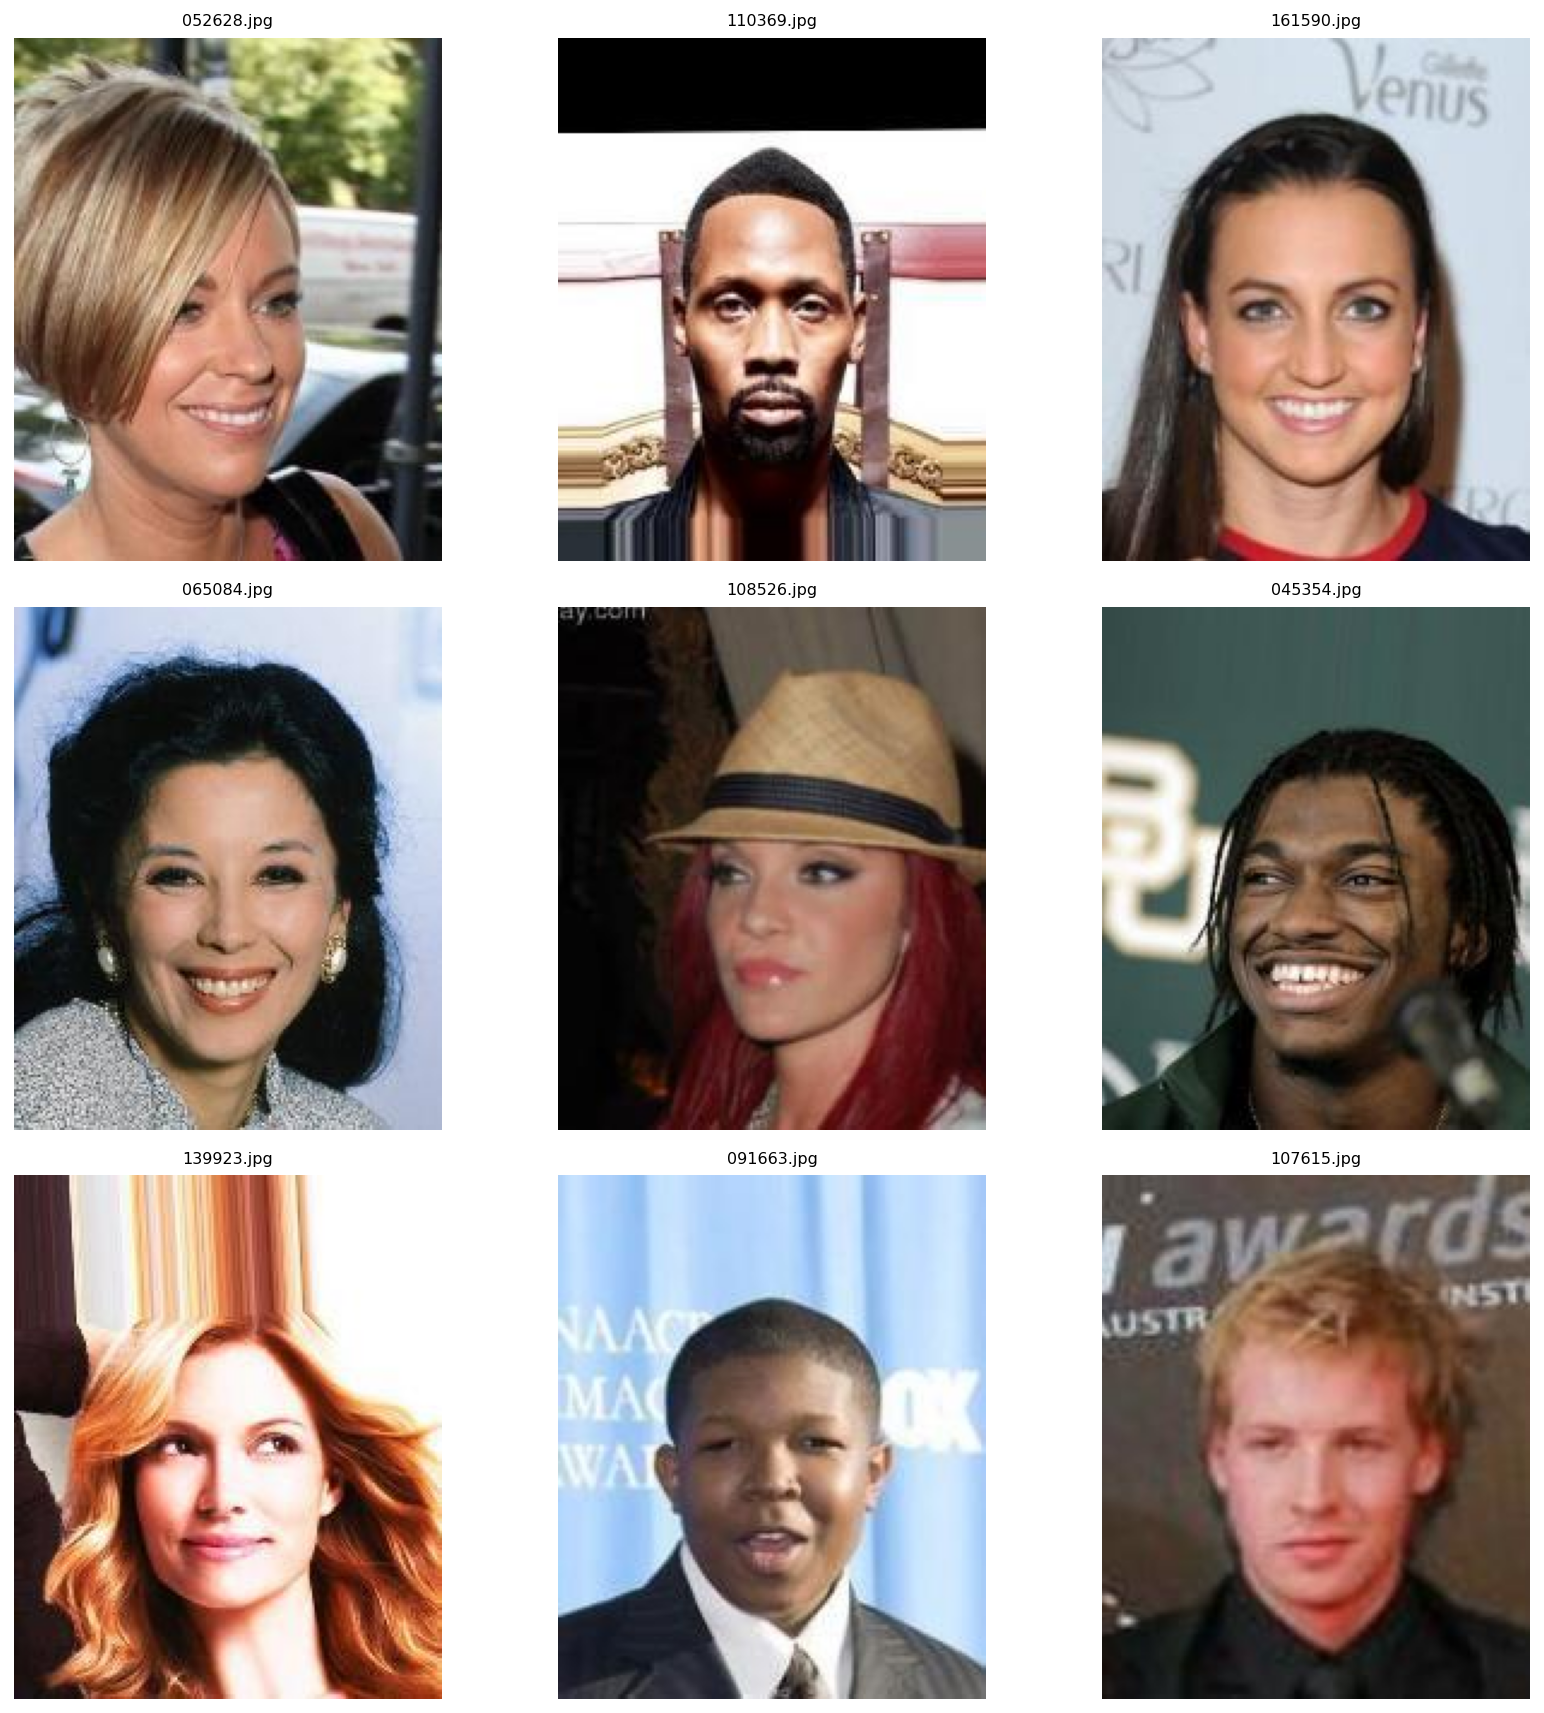


6 random images:


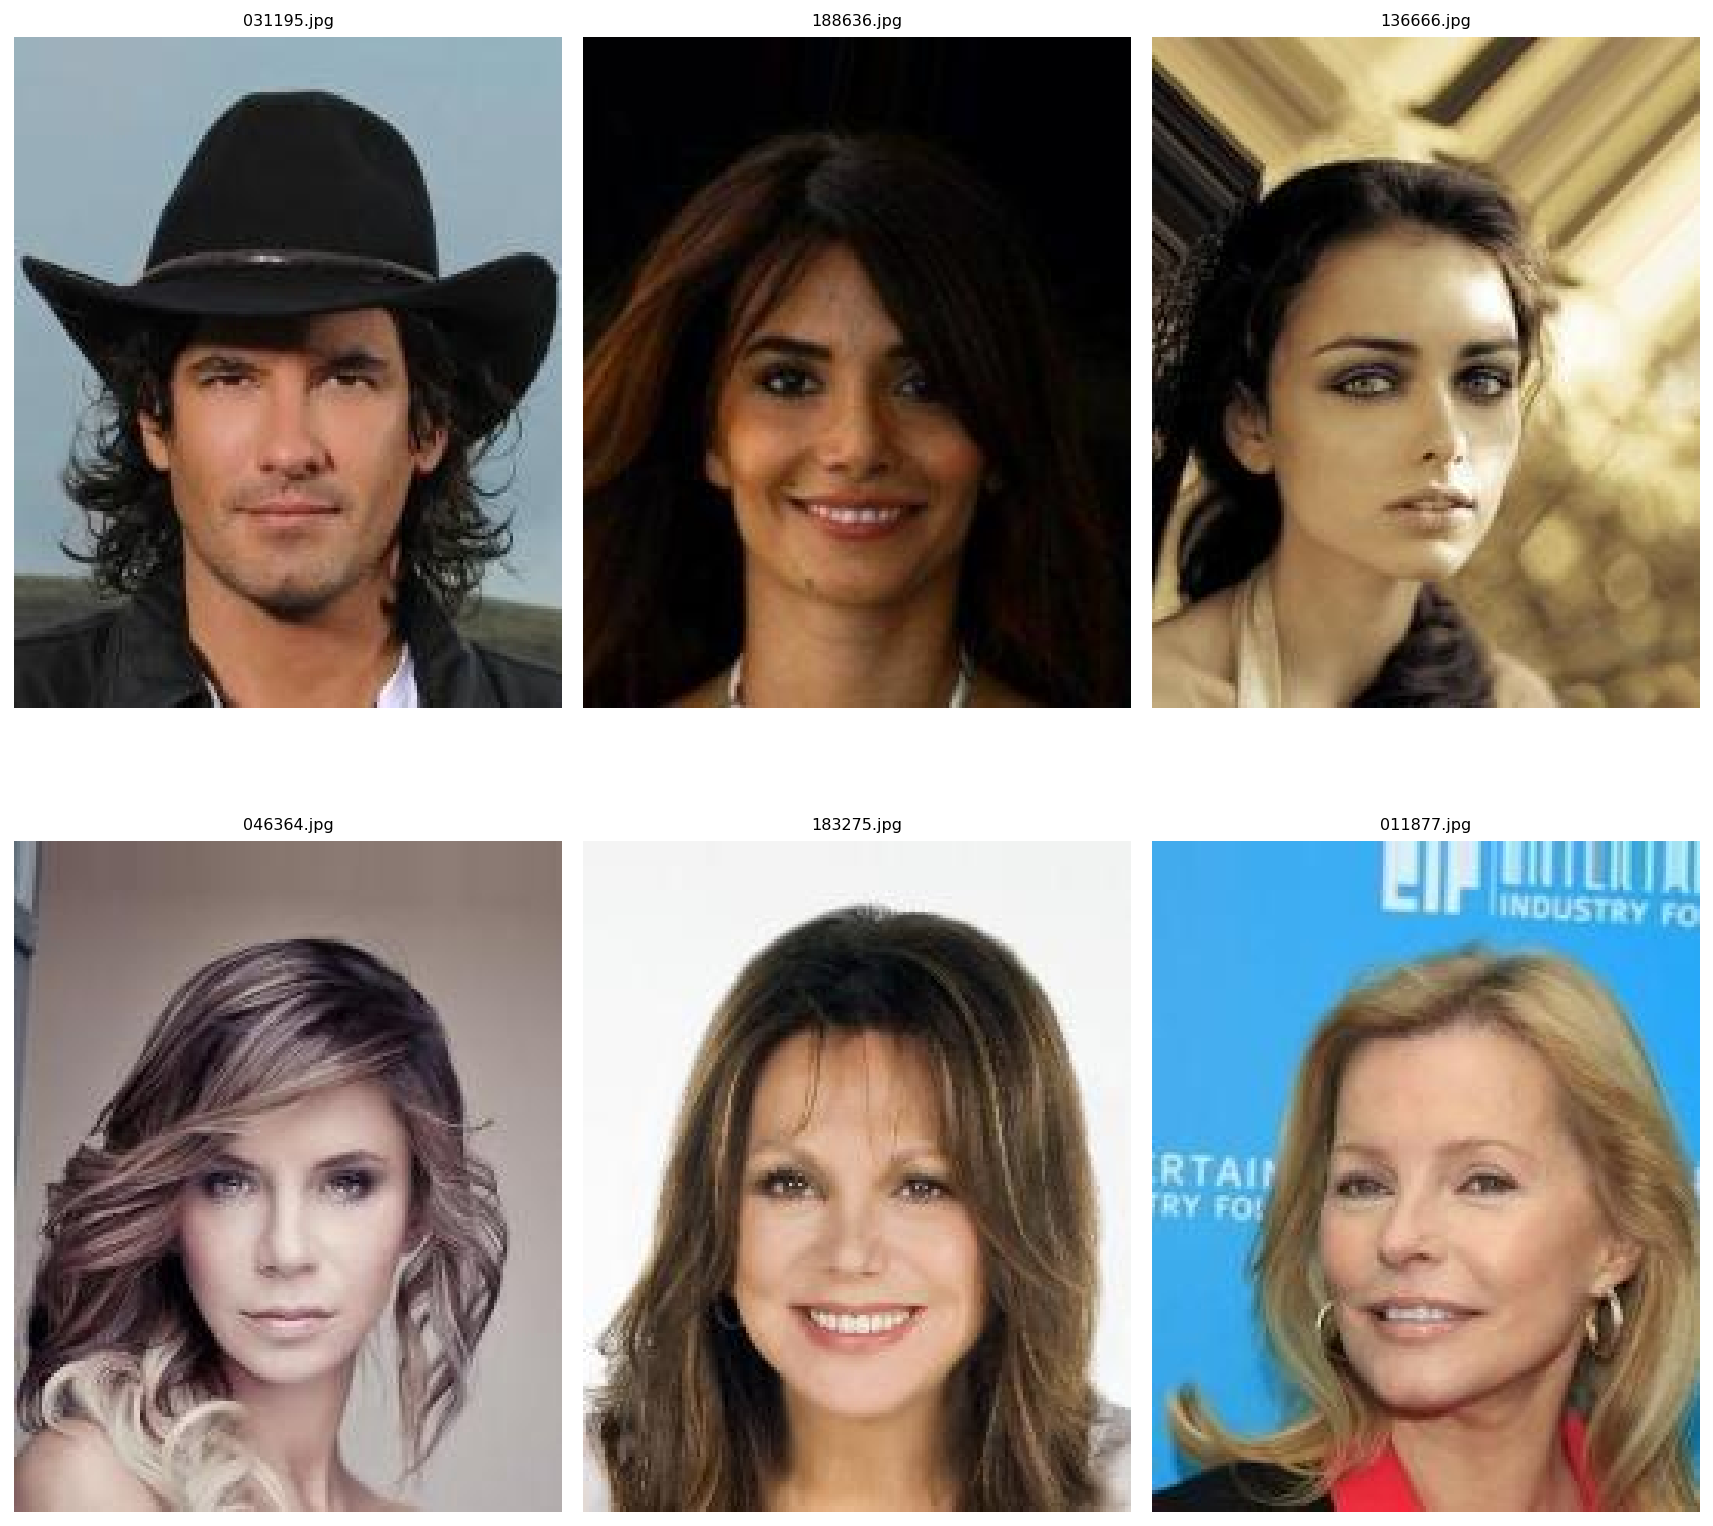


Image at index 100:


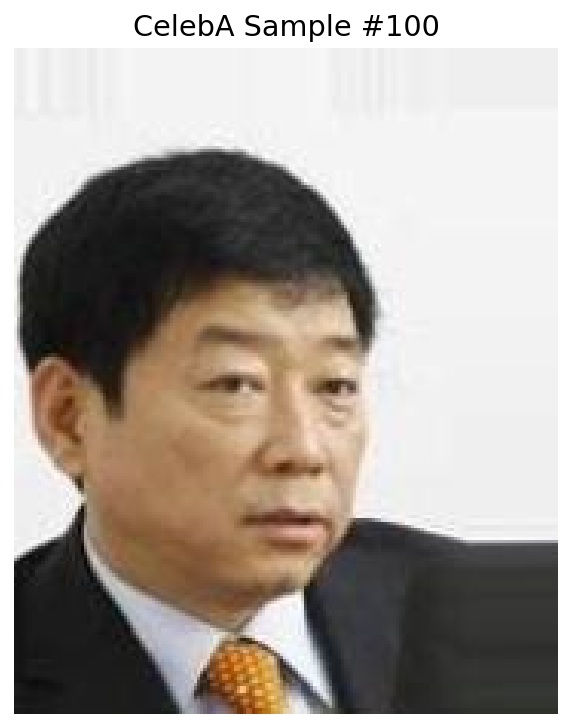

In [22]:
# Example usage of the display functions
if 'img_names' in locals() and img_names:
    print(f"Dataset has {len(img_names)} images")
    
    # Display first 9 images
    print("\nFirst 9 images:")
    display_images(img_names, num_images=9)
    
    # Display 6 random images
    print("\n6 random images:")
    display_random_images(img_names, num_images=6, random_seed=123)
    
    # Display a specific image by index
    print("\nImage at index 100:")
    display_image_by_index(img_names, 100, "CelebA Sample #100")
    
else:
    print("No images loaded yet. Run the image loading cell first.")


In [35]:
# Simple search function
from sentence_transformers import util

def search(query: str, is_image: bool = False, k: int = 8):
    """Search for similar images"""
    if is_image:
        raw = Image.open(query)
        query_emb = model.encode([raw], convert_to_tensor=True, show_progress_bar=False)
        display(raw)
    else:
        query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
        print(f"Query: '{query}'")
    
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print(f"Found {len(hits)} results:")
    result_paths = []  # ✅ Stores file paths
    for i, hit in enumerate(hits):
        img_path = img_names[hit['corpus_id']]
        result_paths.append(img_path)  # ✅ Stores file path (string)
        print(f"{i+1}. {Path(img_path).name} (score: {hit['score']:.3f})")
    
    display_images(result_paths, num_images=len(result_paths))  # ✅ Passes file paths
    return result_paths, hits

print("✅ Search function ready!")


✅ Search function ready!


Testing the simple search function...
TEST 1: Text Search
Query: 'young smiling woman'
Found 6 results:
1. 116404.jpg (score: 0.315)
2. 137152.jpg (score: 0.314)
3. 058203.jpg (score: 0.313)
4. 072229.jpg (score: 0.312)
5. 059776.jpg (score: 0.311)
6. 109074.jpg (score: 0.311)


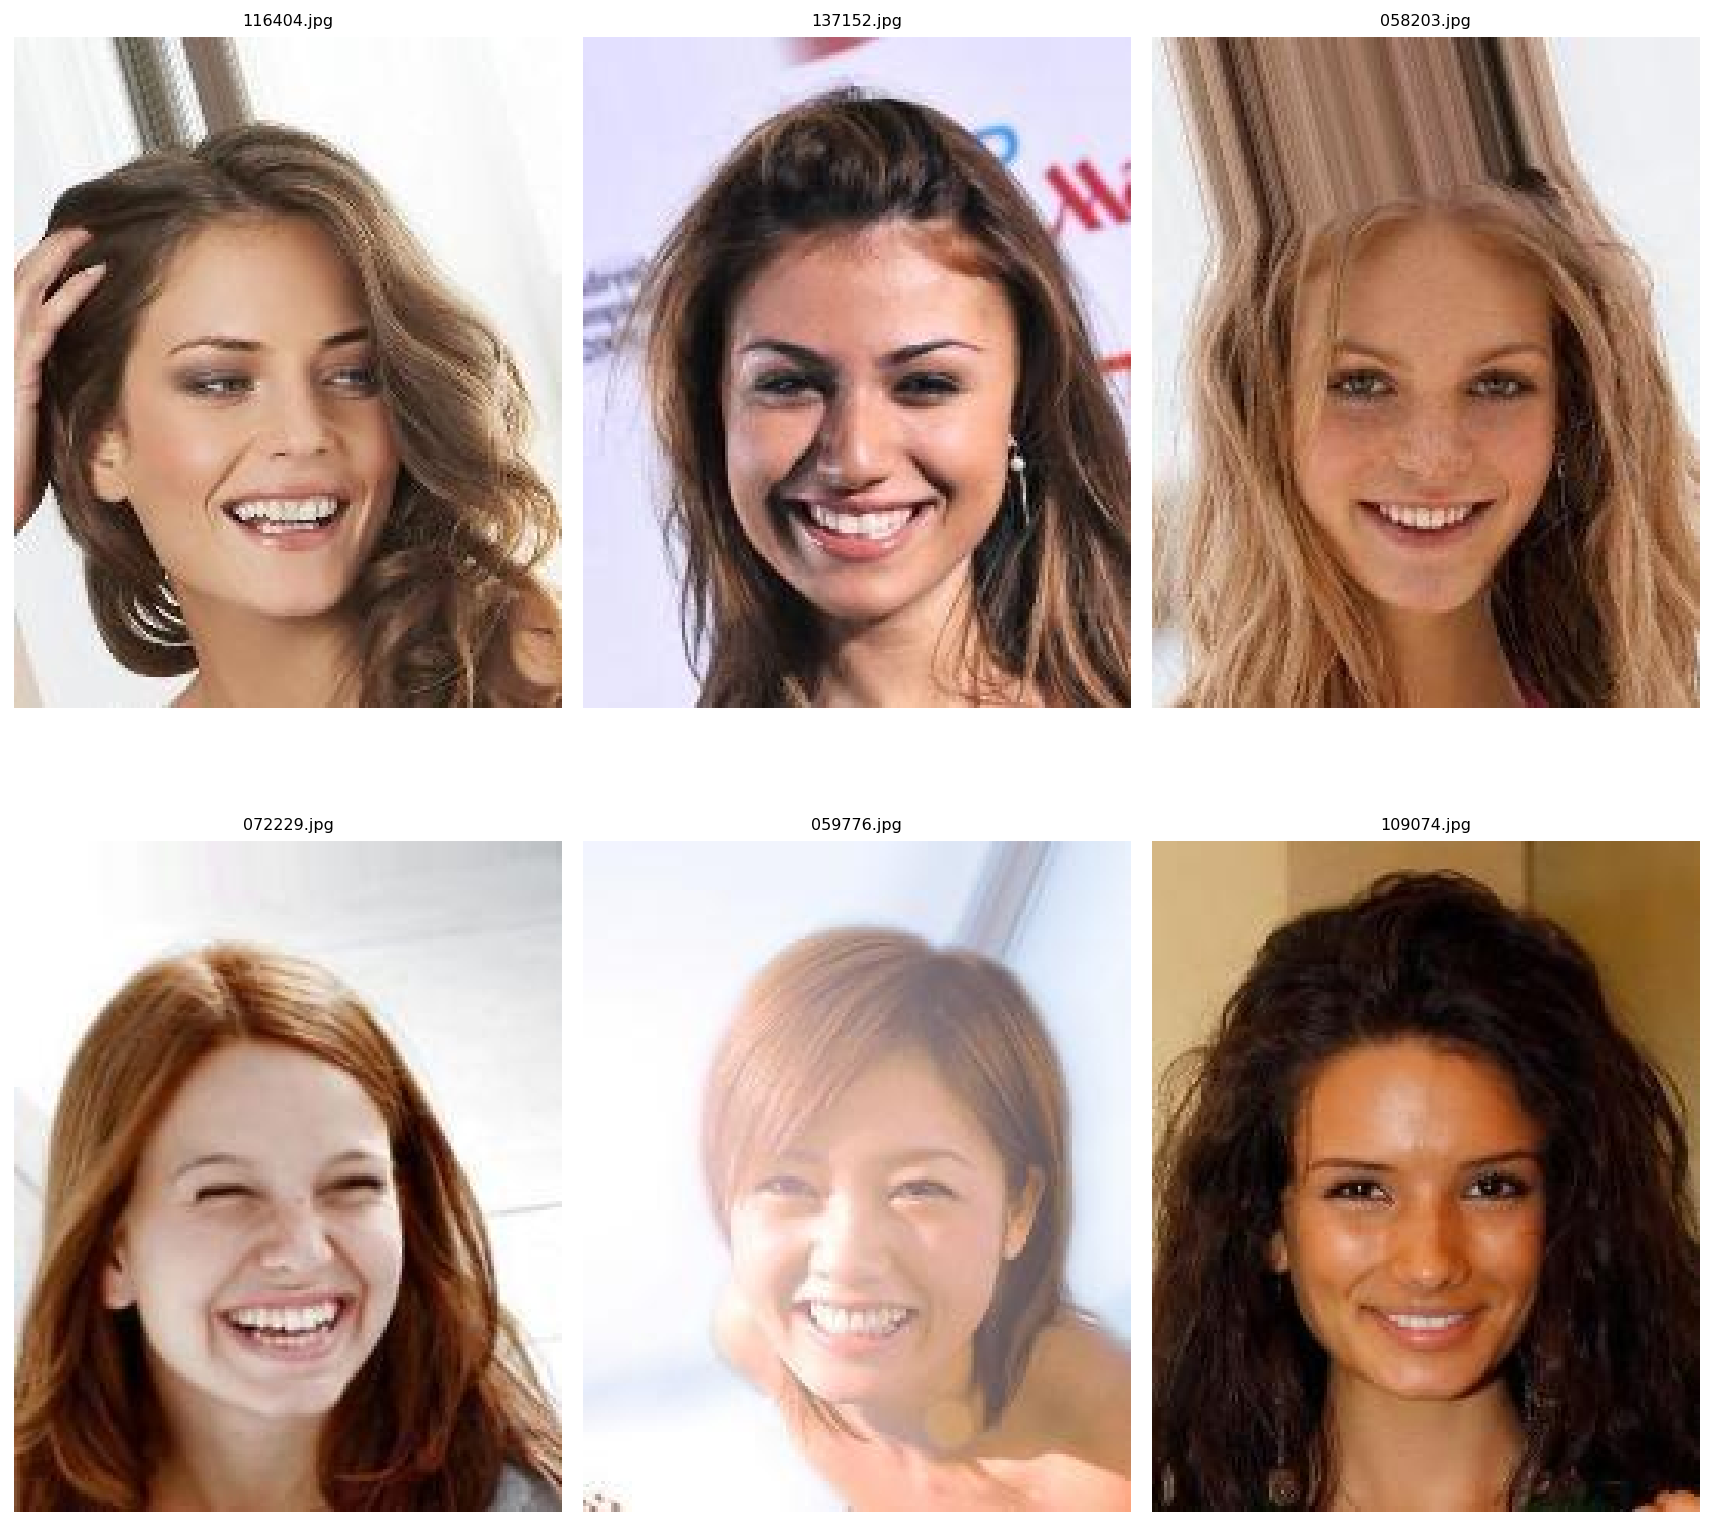


TEST 2: Image Search


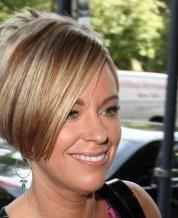

Found 6 results:
1. 052628.jpg (score: 1.000)
2. 106201.jpg (score: 0.898)
3. 197250.jpg (score: 0.895)
4. 025799.jpg (score: 0.885)
5. 194106.jpg (score: 0.880)
6. 092321.jpg (score: 0.876)


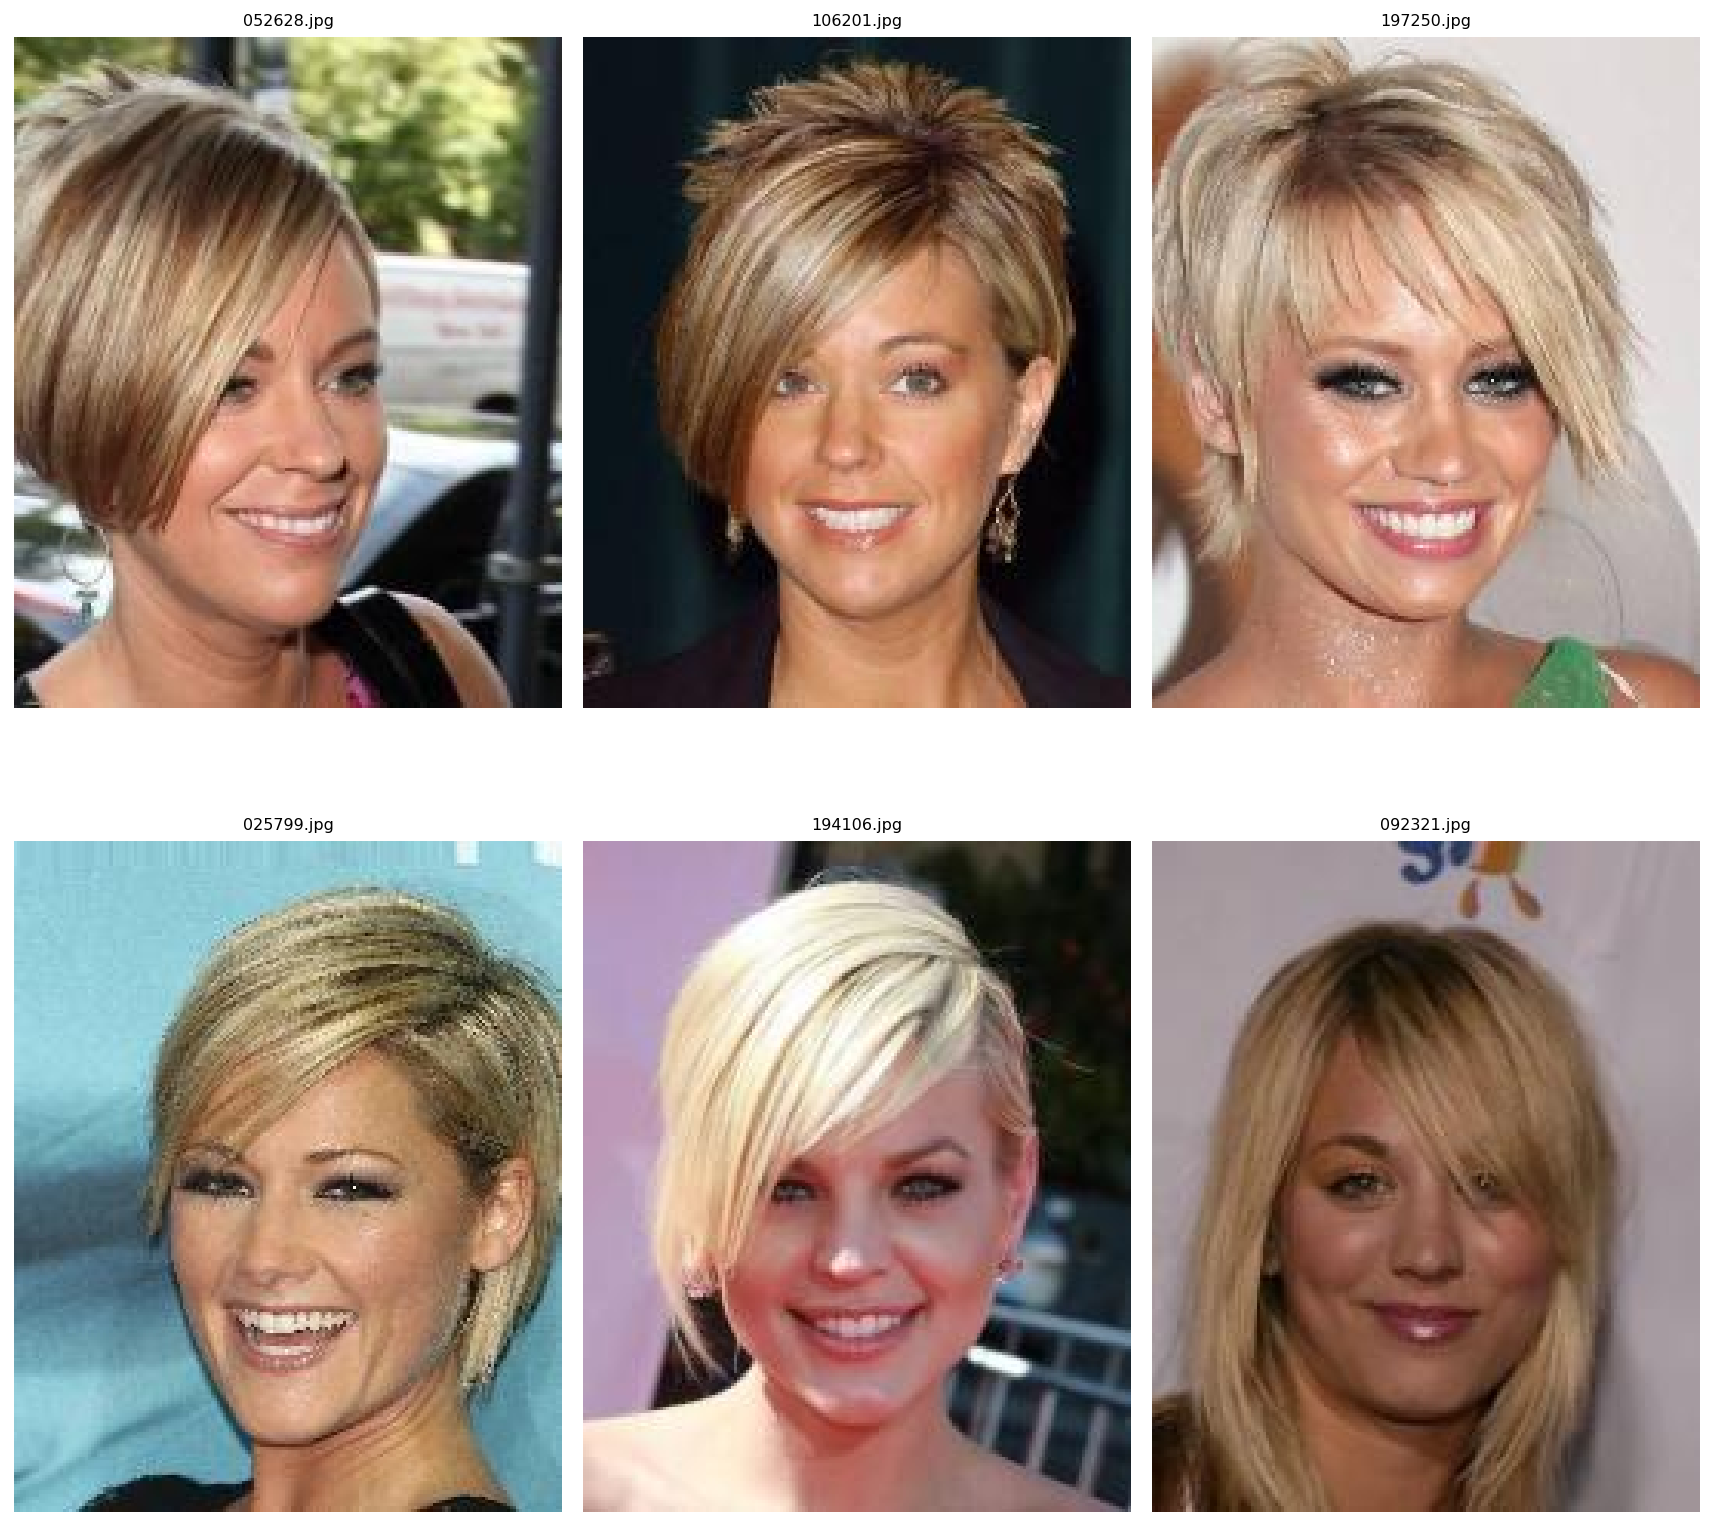


TEST 3: Different Text Queries

--- Query: 'serious man with glasses' ---
Query: 'serious man with glasses'
Found 4 results:
1. 168561.jpg (score: 0.311)
2. 124326.jpg (score: 0.308)
3. 106632.jpg (score: 0.307)
4. 042314.jpg (score: 0.305)


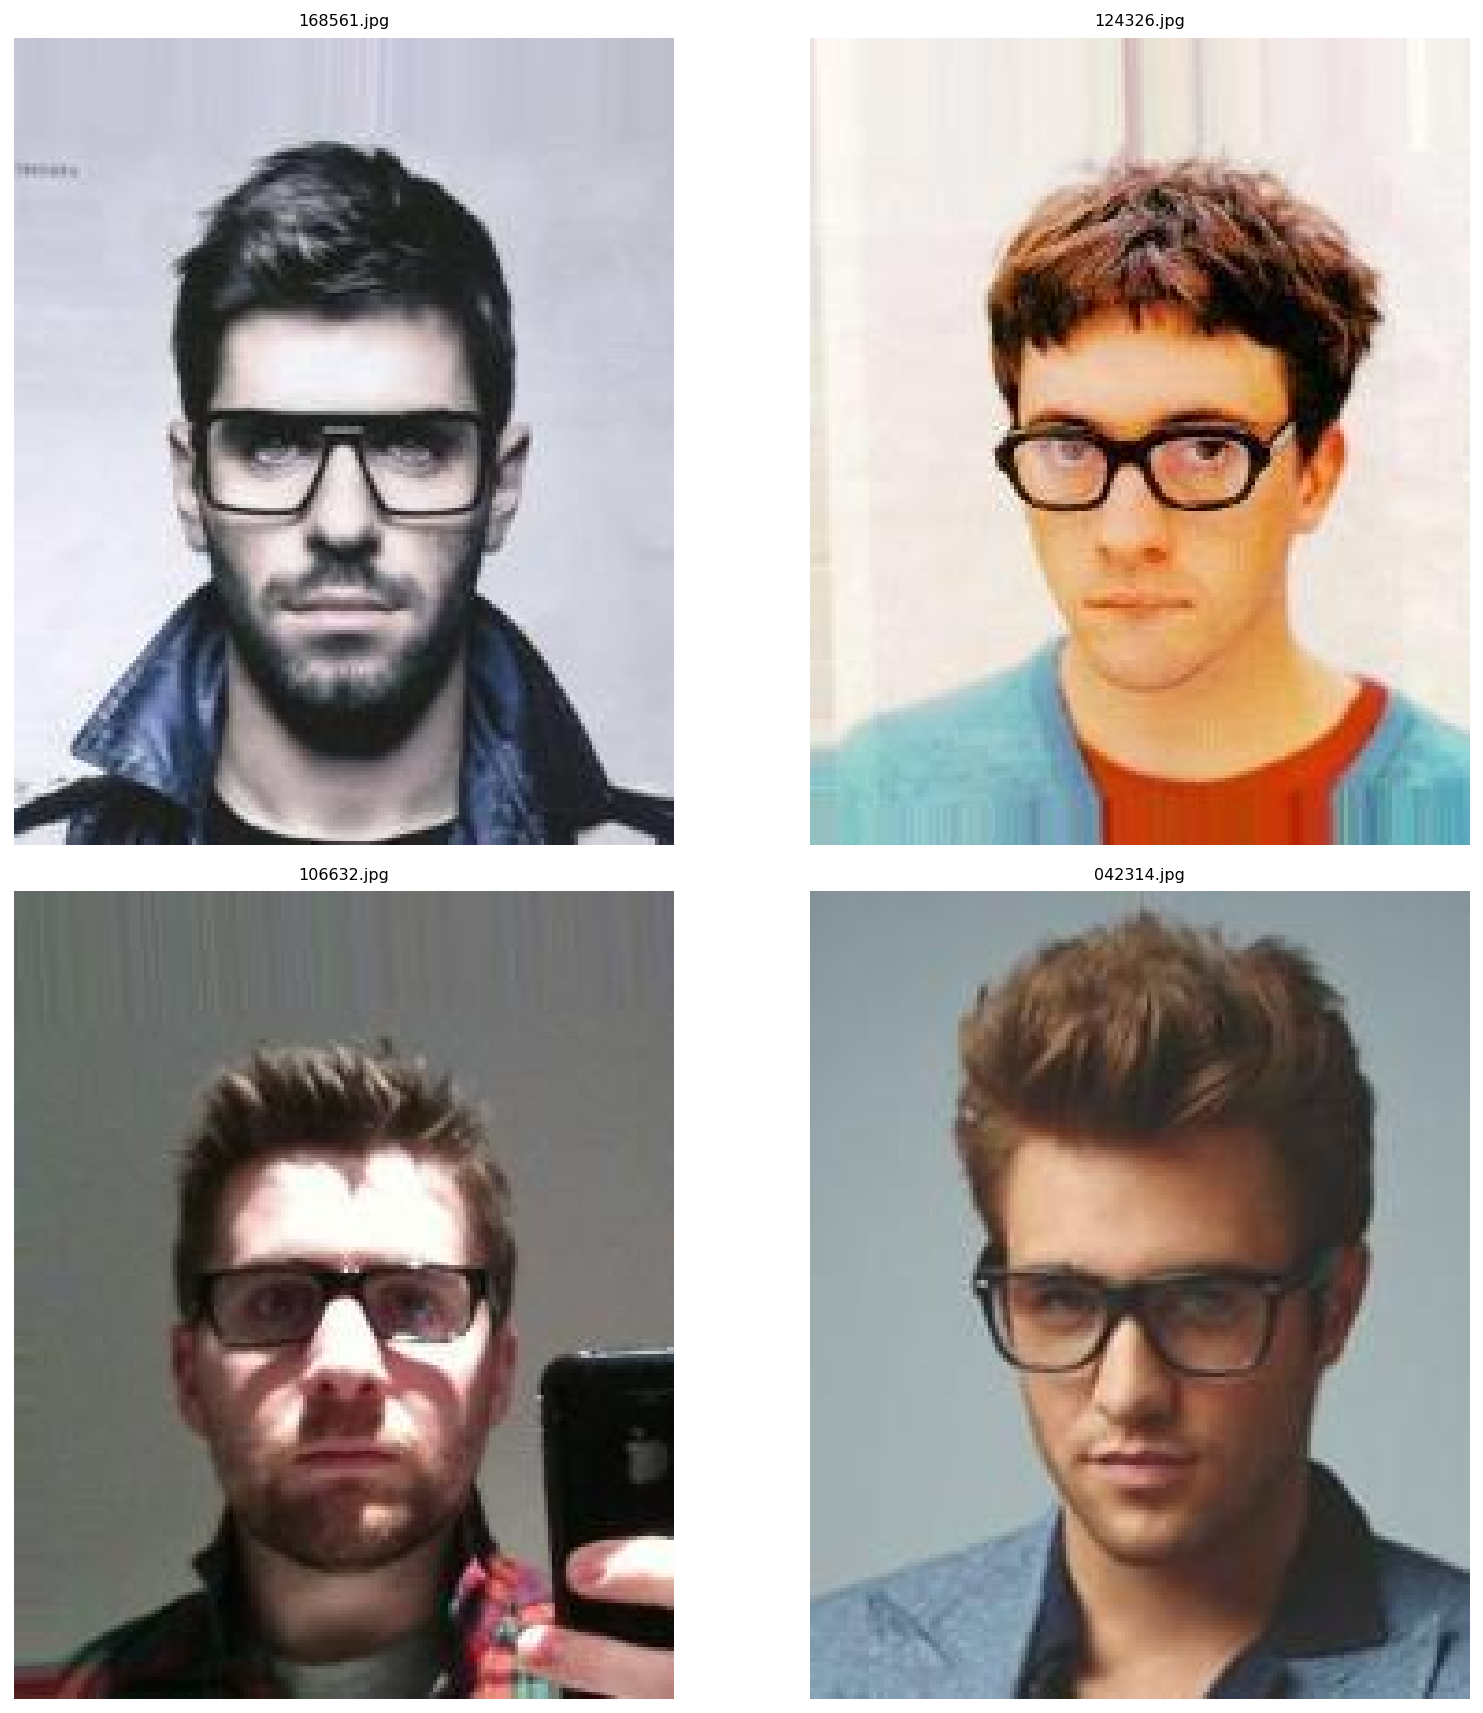


--- Query: 'happy young person' ---
Query: 'happy young person'
Found 4 results:
1. 054660.jpg (score: 0.270)
2. 089882.jpg (score: 0.267)
3. 157883.jpg (score: 0.266)
4. 086407.jpg (score: 0.266)


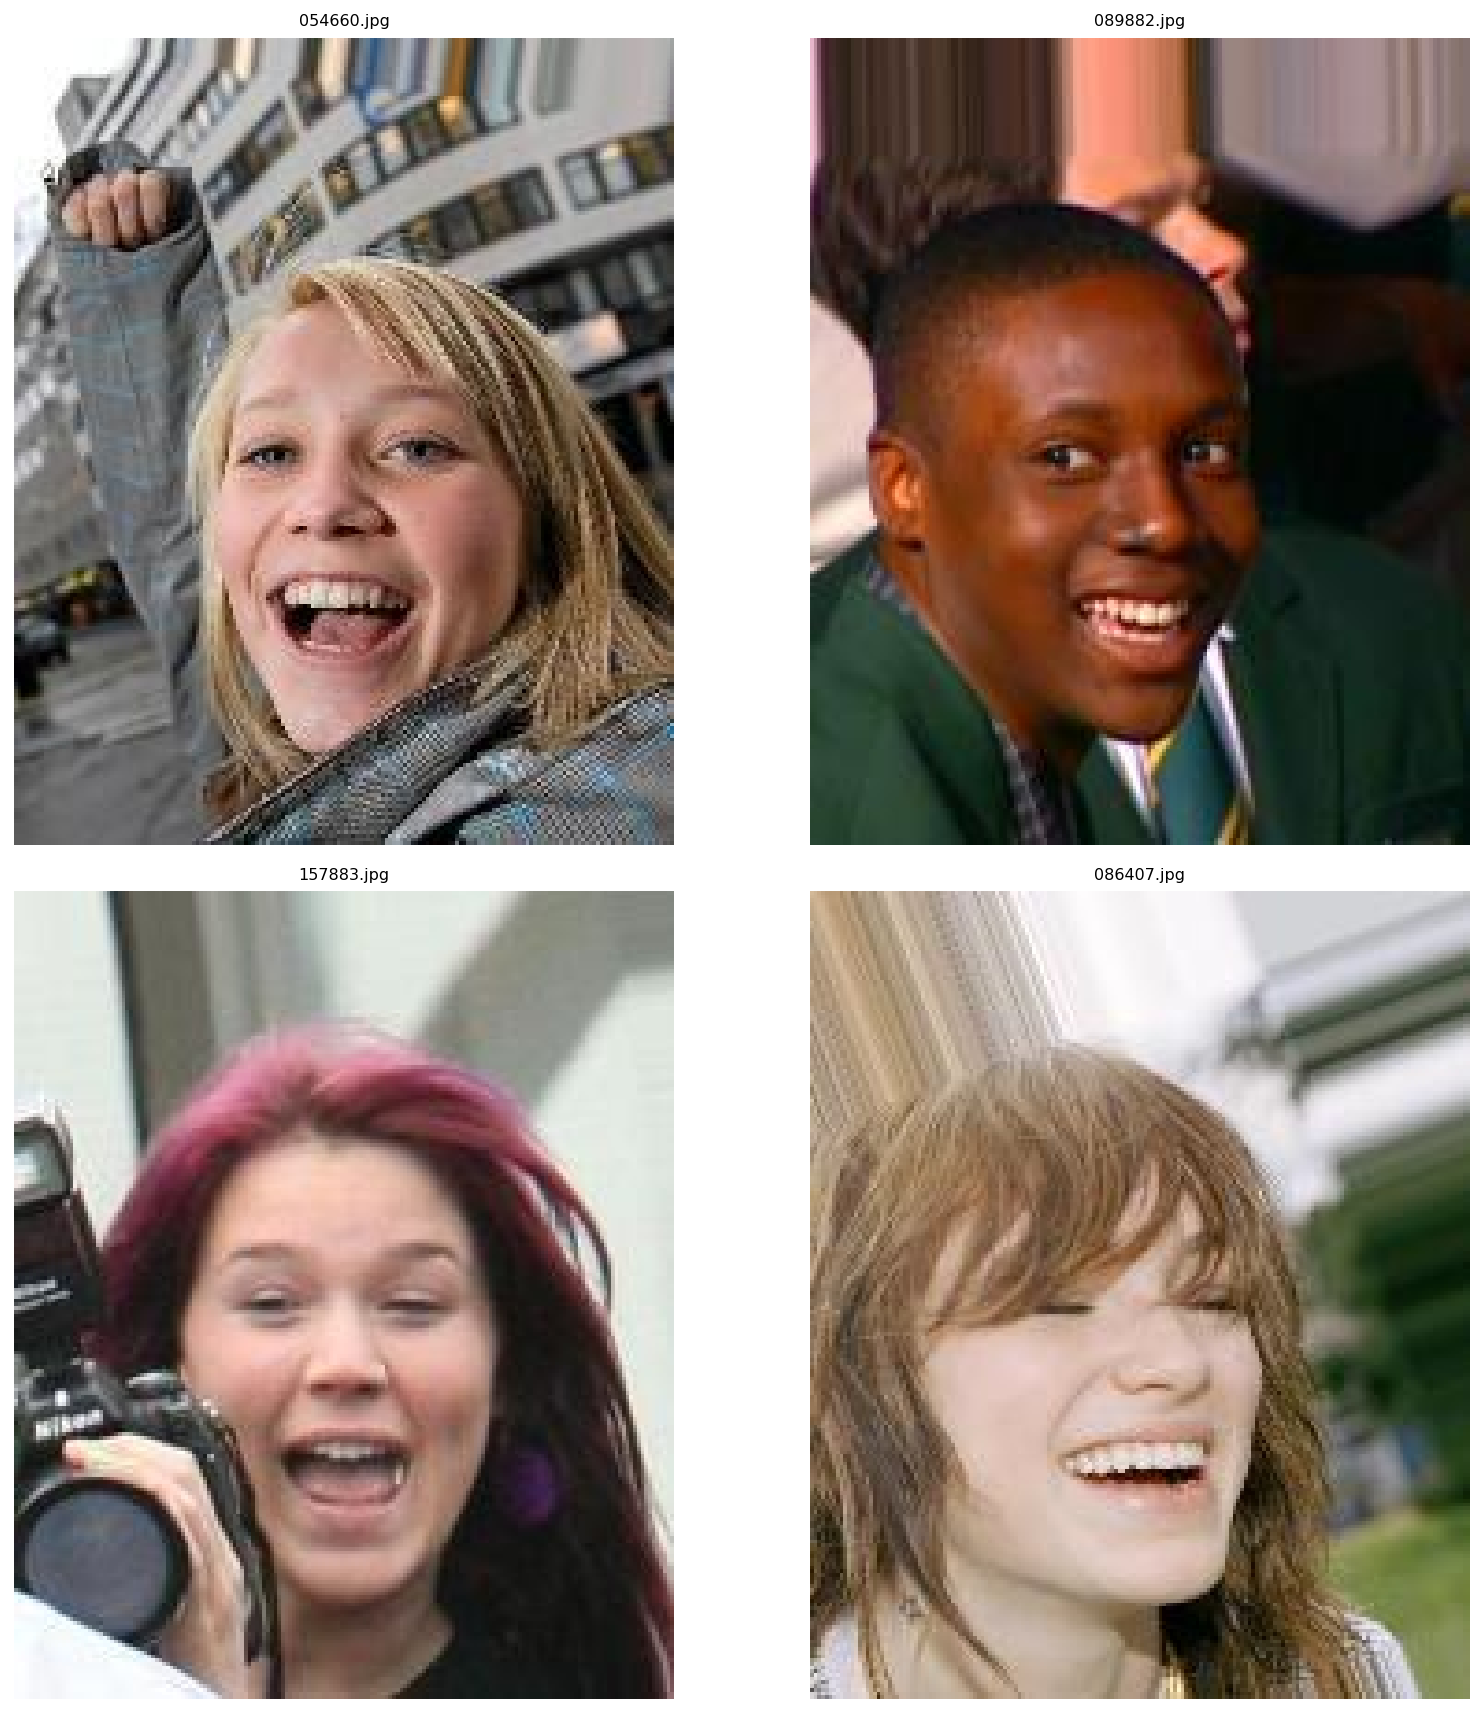


--- Query: 'person with beard' ---
Query: 'person with beard'
Found 4 results:
1. 111806.jpg (score: 0.307)
2. 174917.jpg (score: 0.306)
3. 148585.jpg (score: 0.304)
4. 092843.jpg (score: 0.302)


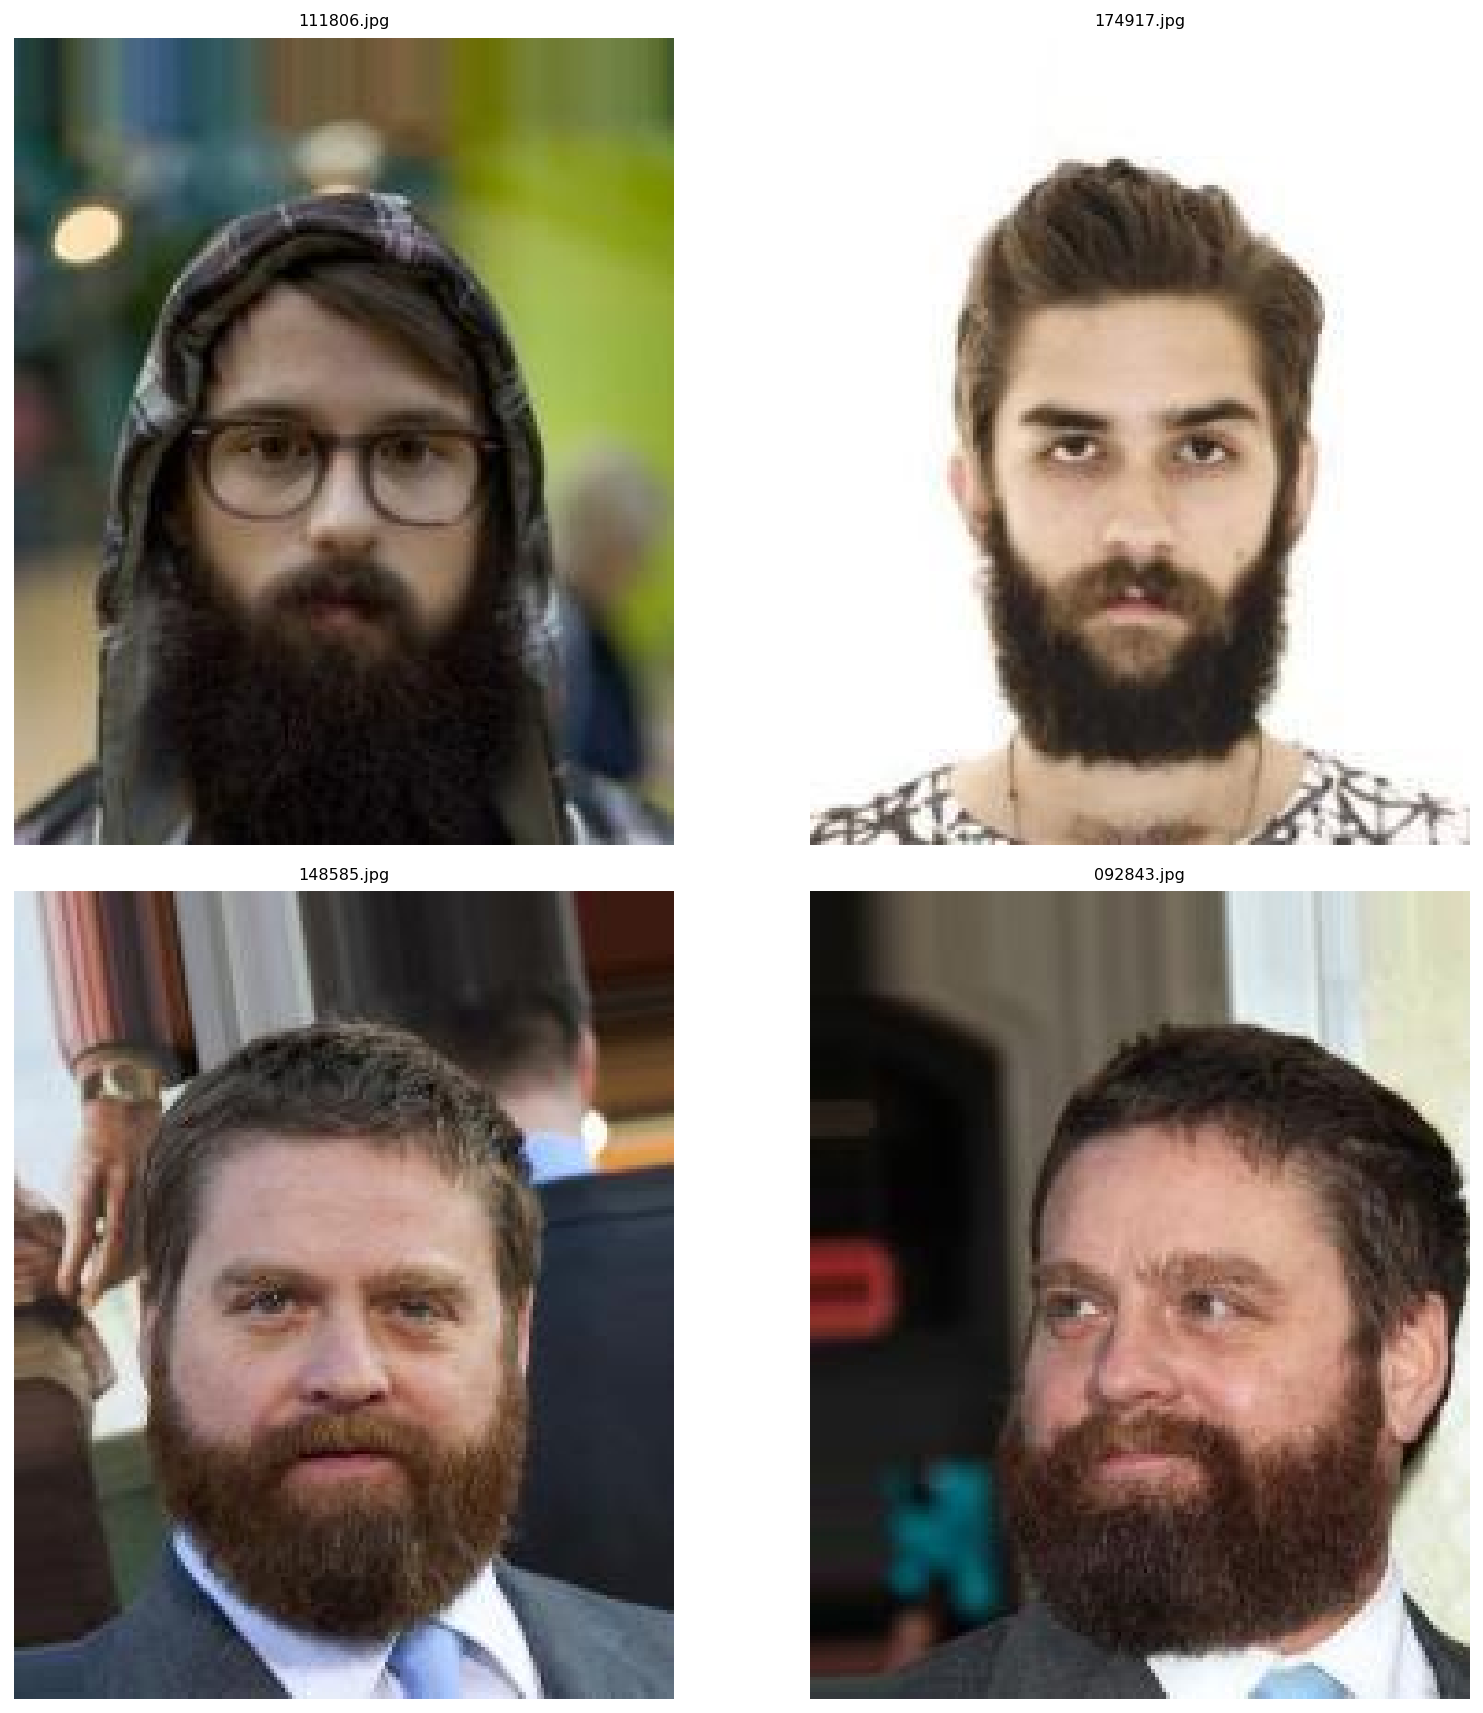

In [ ]:
# Test the simple search function
if 'img_names' in locals() and 'img_emb' in locals():
    print("Testing the simple search function...")
    
    # Test 1: Text search
    print("=" * 50)
    print("TEST 1: Text Search")
    print("=" * 50)
    results1, hits1 = search("young smiling woman", is_image=False, k=6)
    
    print("\n" + "=" * 50)
    print("TEST 2: Image Search")
    print("=" * 50)
    # Test 2: Image search (use first image as query)
    if len(img_names) > 0:
        query_image = img_names[0]
        results2, hits2 = search(query_image, is_image=True, k=6)
    else:
        print("No images available for image search test")
    
    print("\n" + "=" * 50)
    print("TEST 3: Different Text Queries")
    print("=" * 50)
    # Test 3: Different text queries
    text_queries = [
        "serious man with glasses",
        "happy young person",
        "person with beard"
    ]
    
    for query in text_queries:
        print(f"\n--- Query: '{query}' ---")
        try:
            results, hits = search(query, is_image=False, k=4)
        except Exception as e:
            print(f"Error with query '{query}': {e}")
    
else:
    print("Please run the previous cells to load images and embeddings first.")
    print("Then run this cell to test the search function.")


In [ ]:
# Fixed version: Display images with their attributes
if 'img_names' in locals() and 'df_attributes_fixed' in locals() and df_attributes_fixed is not None:
    print("Displaying sample images with their attributes:")
    
    # Display first few images with attributes
    for i in range(min(3, len(img_names))):
        print(f"\n--- Image {i+1} ---")
        display_image_with_attributes(img_names[i], df_attributes_fixed)
        
else:
    print("No images or attributes loaded yet.")
    print("Run the previous cells to load the dataset and attributes first.")


Displaying sample images with their attributes:

--- Image 1 ---
Image 052628.jpg not found in attributes

--- Image 2 ---
Image 110369.jpg not found in attributes

--- Image 3 ---
Image 161590.jpg not found in attributes


In [ ]:
# Find happy people
smiling_people = search_by_attributes('Smiling', 1, df_attributes_clean, img_names, img_emb, top_k=20)

# Find serious/neutral expressions
serious_people = search_by_attributes('Smiling', -1, df_attributes_clean, img_names, img_emb, top_k=20)
suspect_description = "young man with glasses and beard"
matches = search_by_text_description(suspect_description, img_names, img_emb, top_k=10)
# Find people with specific characteristics
witness_description = "smiling young woman with blonde hair"
witness_matches = search_by_text_description(witness_description, img_names, img_emb, top_k=15)

Attribute 'Smiling' not found!
Attribute 'Smiling' not found!


In [ ]:
smiling_people

[]

In [ ]:
matches

[('/Users/sankar/sankar/courses/llm/data/celeba/img_align_celeba/img_align_celeba/050156.jpg',
  np.float32(0.3317916)),
 ('/Users/sankar/sankar/courses/llm/data/celeba/img_align_celeba/img_align_celeba/166210.jpg',
  np.float32(0.3180605)),
 ('/Users/sankar/sankar/courses/llm/data/celeba/img_align_celeba/img_align_celeba/202141.jpg',
  np.float32(0.31508744)),
 ('/Users/sankar/sankar/courses/llm/data/celeba/img_align_celeba/img_align_celeba/154043.jpg',
  np.float32(0.31491375)),
 ('/Users/sankar/sankar/courses/llm/data/celeba/img_align_celeba/img_align_celeba/173669.jpg',
  np.float32(0.31251615)),
 ('/Users/sankar/sankar/courses/llm/data/celeba/img_align_celeba/img_align_celeba/111806.jpg',
  np.float32(0.3120261)),
 ('/Users/sankar/sankar/courses/llm/data/celeba/img_align_celeba/img_align_celeba/159624.jpg',
  np.float32(0.31064075)),
 ('/Users/sankar/sankar/courses/llm/data/celeba/img_align_celeba/img_align_celeba/168561.jpg',
  np.float32(0.3091404)),
 ('/Users/sankar/sankar/cour

In [ ]:
# WORKING search function (no ipyplot dependency)
from typing import Union
from sentence_transformers import util

def search(query: str, is_image: bool = False, k: int = 8):
    """
    Working search function that doesn't require ipyplot
    """
    # Load query (image or text)
    if is_image:
        raw = Image.open(query)
        query_emb = model.encode([raw], convert_to_tensor=True, show_progress_bar=False)
        print(f"🔍 Image Query: {Path(query).name}")
        display(raw)
    else:
        query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
        print(f"🔍 Text Query: '{query}'")
    
    # Use util.semantic_search for cosine similarity
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print(f"\n📊 Found {len(hits)} results:")
    print("-" * 60)
    
    # Get result images
    result_images = []
    result_paths = []
    
    for i, hit in enumerate(hits):
        img_path = img_names[hit['corpus_id']]
        result_paths.append(img_path)
        
        try:
            img = Image.open(img_path)
            result_images.append(img)
            filename = Path(img_path).name
            print(f"{i+1:2d}. {filename} (score: {hit['score']:.3f})")
        except Exception as e:
            print(f"{i+1:2d}. Error loading {Path(img_path).name}: {e}")
    
    # Display results using matplotlib (no ipyplot needed)
    if result_images:
        print(f"\n🖼️  Displaying {len(result_images)} results:")
        display_images(result_images, num_images=len(result_images))
    
    return result_paths, hits

print("✅ Working search function ready!")
print("Usage: search('your query', is_image=False, k=8)")

In [ ]:
search

<function __main__.search(query: str, is_image: bool = False, k: int = 8)>

In [63]:
search('Happy Woman')

Query:
/Users/sankar/sankar/courses/llm/data/celeba/img_align_celeba/img_align_celeba


'Happy Woman'

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/sankar/sankar/courses/llm/person_of_interest/.venv/lib/python3.12/site-packages/PIL/Image │
│ .py:3308 in fromarray                                                                            │
│                                                                                                  │
│   3305 │   │   │   msg = "Cannot handle this data type"                                          │
│   3306 │   │   │   raise TypeError(msg) from e                                                   │
│   3307 │   │   try:                                                                              │
│ ❱ 3308 │   │   │   mode, rawmode = _fromarray_typemap[typekey]                                   │
│   3309 │   │   except KeyError as e:                                                             │
│   3310 │   │   │   typekey_shape, typestr = typekey                                              │
│   3311 │   │   │   msg = f"Cannot handle this data type: {typekey_shape}, {typestr}"             │
│                                                                                                  │
│ ╭─────────────────────────────────── locals ────────────────────────────────────╮                │
│ │           arr = {                                                             │                │
│ │                 │   'data': (4854415360, False),                              │                │
│ │                 │   'strides': None,                                          │                │
│ │                 │   'descr': [('', '|O')],                                    │                │
│ │                 │   'typestr': '|O',                                          │                │
│ │                 │   'shape': (218, 178, 3),                                   │                │
│ │                 │   'version': 3                                              │                │
│ │                 }                                                             │                │
│ │          mode = None                                                          │                │
│ │           msg = 'Cannot handle this data type: (1, 1, 3), |O'                 │                │
│ │          ndim = 3                                                             │                │
│ │           obj = array([[[120, 122, 121],                                      │                │
│ │                 │   │   [122, 124, 123],                                      │                │
│ │                 │   │   [125, 127, 126],                                      │                │
│ │                 │   │   ...,                                                  │                │
│ │                 │   │   [103, 127, 127],                                      │                │
│ │                 │   │   [104, 125, 126],                                      │                │
│ │                 │   │   [104, 126, 124]],                                     │                │
│ │                 │                                                             │                │
│ │                 │      [[121, 123, 122],                                      │                │
│ │                 │   │   [123, 125, 124],                                      │                │
│ │                 │   │   [125, 127, 126],                                      │                │
│ │                 │   │   ...,                                                  │                │
│ │                 │   │   [103, 127, 127],                                      │                │
│ │                 │   │   [103, 124, 125],                                      │                │
│ │                 │   │   [103, 125, 123]],                                     │                │
│ │                 │                                        

In [59]:
# Basic search
results, hits = search_fixed("young smiling celebrity", is_image=False, k=6)

# Celebrity search with attributes
results, hits, attrs = celebrity_search_fixed("famous actor", is_image=False, k=8)

# Image search
results, hits, attrs = celebrity_search_fixed(img_names[0], is_image=True, k=6)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Basic search                                                                               │
│ ❱ 2 results, hits = search_fixed("young smiling celebrity", is_image=False, k=6)                 │
│   3                                                                                              │
│   4 # Celebrity search with attributes                                                           │
│   5 results, hits, attrs = celebrity_search_fixed("famous actor", is_image=False, k=8)           │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │             all_embeddings = [                                                               │ │
│ │                              │   tensor([[ 0.2858, -0.2847, -0.2640,  ...,  0.3011,  0.1638, │ │
│ │                              0.0452],                                                        │ │
│ │                              │   │   [ 0.2221, -0.1362, -0.2651,  ..., -0.2057, -0.2366,     │ │
│ │                              -0.2732],                                                       │ │
│ │                              │   │   [ 0.4981, -0.0162, -0.0032,  ...,  0.7702, -0.1730,     │ │
│ │                              0.2258],                                                        │ │
│ │                              │   │   ...,                                                    │ │
│ │                              │   │   [ 0.2912, -0.1686, -0.0724,  ...,  0.2087,  0.1178,     │ │
│ │                              -0.0425],                                                       │ │
│ │                              │   │   [ 0.3114, -0.2897, -0.1063,  ..., -0.1117, -0.3097,     │ │
│ │                              0.0579],                                                        │ │
│ │                              │   │   [ 0.8052, -0.2154, -0.3759,  ...,  0.1970,  0.0496,     │ │
│ │                              0.2447]],                                                       │ │
│ │                              │      device='mps:0'),                                         │ │
│ │                              │   tensor([[ 0.1710,  0.3562, -0.0405,  ...,  0.6980,  0.0720, │ │
│ │                              0.1632],                                                        │ │
│ │                              │   │   [ 0.3971,  0.0459, -0.4541,  ..., -0.2454,  0.1838,     │ │
│ │                              0.0171],                                                        │ │
│ │                              │   │   [-0.1254, -0.1048, -0.0237,  ...,  0.4051, -0.2246,     │ │
│ │                              0.0302],                                                        │ │
│ │                              │   │   ...,                                                    │ │
│ │                              │   │   [ 0.3814, -0.3073, -0.1045,  ...,  0.2428, -0.1096,     │ │
│ │                              -0.1353],                                                       │ │
│ │                              │   │   [ 0.2459, -0.1925,  0.0239,  ...,  0.8330,  0.3410,     │ │
│ │                              0.1842],                                                        │ │
│ │                              │   │   [ 0.5591,  0.0155, -0.0673,  ...,  0.3753,  0.0990,     │ │
│ │                              0.6688]],                                                       │ │
│ │                              │      device='mps:0'),                                         │ │
│ │                              │   tensor([[ 0.6897,  0.126